# Chapter 2: End-to-End Machine Learning Project

## Downloading the California Housing Dataset

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("..", "data")
HOUSING_URL = DOWNLOAD_ROOT + "data/housing/housing.tgz"

# function to fetch the data
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

## Getting a feel of the data

In [2]:
# function to load the data
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
# loading the data
housing = load_housing_data()
# taking a quick look at the data
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info() # viewing data types and missing values per column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing['ocean_proximity'].value_counts() # viewing number of categories in the `ocean_proximity` field

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe() #viewing summary statistics of numerical columns (missing values are ignored)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


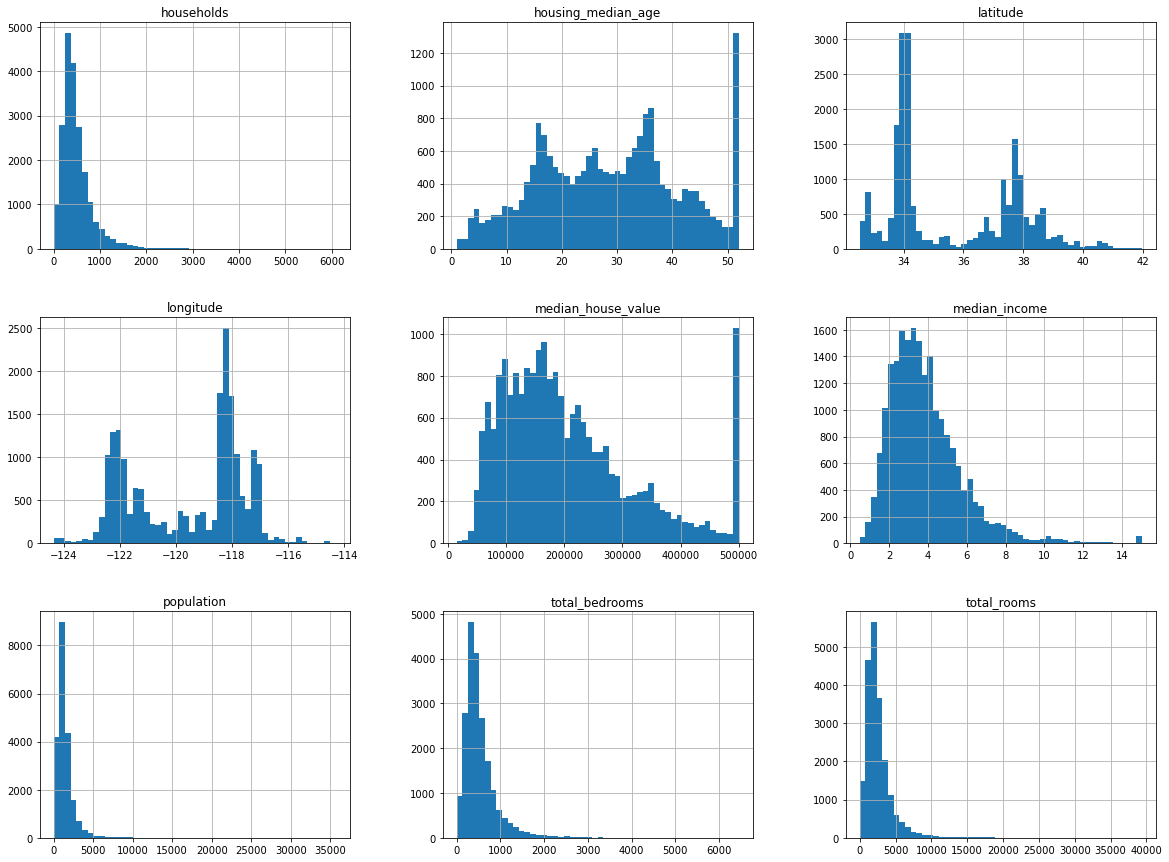

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))
plt.show()

## Creating a test set

### Random sampling methods

We can create a test set this way:

```python
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
```
However, the method above generates a random test set each time.

In [8]:
# create a hash for each instance, so that even when new instances
# are added, some instances in the original test set don't enter
# the training set
from zlib import crc32
import numpy as np

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

The housing dataset doesn't have an ID column. The easiest solution is to use row indices. 
```python
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
```

The downside is that we'd have to make sure that:
1. additional data is always appended
2. no data gets deleted

In [9]:
# a better alternative - derive an ID column from stable/immutable features
housing["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing, 0.2, "id")

print('Training set examples: {} \nTest set examples: {}'.\
      format(len(train_set), len(test_set)))

Training set examples: 16322 
Test set examples: 4318


Scikit-learn has a `train_test_split` function that works similarly to the `split_train_test` indicated earlier, but has more features.

```python
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
```

**Note:** The location information is actually quite coarse, and as a result many districts will have the exact same ID, so they will end up in the same set (test or train). This introduces some unfortunate sampling bias.

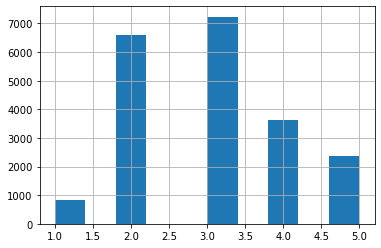

In [10]:
# making a categorical feature from `median_income`
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

# viewing the distrubution of income categories using a histogram
housing["income_cat"].hist();

### Stratified sampling

Income is a very important factor in determining house prices. We therefore perform stratified sampling based on income, since we don't want to introduce significant sampling bias in our model.

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [12]:
# looking at income category proportions in the test set
# to confirm that the stratified split was succcessful
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [13]:
# creating random samples with the categorical income column
train_set, test_set = split_train_test_by_id(housing, 0.2, "id")

# comparing sampling bias between random and stratified sampling
sampling_bias = {'Overall': housing["income_cat"].value_counts() / len(housing),
                 'Random': test_set["income_cat"].value_counts() / len(test_set),
                 'Stratified': strat_test_set["income_cat"].value_counts() / len(strat_test_set),             
                }
df_sampling_bias = pd.DataFrame(sampling_bias).sort_index()
df_sampling_bias['Rand. % error'] = (df_sampling_bias.Random - df_sampling_bias.Overall
                                    )/df_sampling_bias.Overall * 100
df_sampling_bias['Strat. % error'] = (df_sampling_bias.Stratified - df_sampling_bias.Overall
                                     )/df_sampling_bias.Overall * 100
df_sampling_bias

,Overall,Random,Stratified,Rand. % error,Strat. % error
1,0.039826,0.039833,0.039729,0.019271,-0.243309
2,0.318847,0.321214,0.318798,0.742245,-0.015195
3,0.350581,0.366142,0.350533,4.438438,-0.013820
4,0.176308,0.171144,0.176357,-2.929015,0.027480
5,0.114438,0.101667,0.114583,-11.159359,0.127011


In [14]:
# restoring the data to its original state
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Exploratory Data Analysis

First put the test set aside, and only explore the training set.If the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast. In our case, the training set is quite small, so we can work directly on the full training set.

In [15]:
# copy the training set to avoid modifying it
housing = strat_train_set.copy()

### Visualizing geographic data

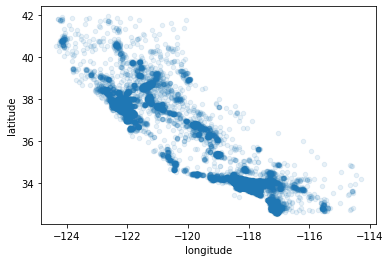

In [16]:
# a scatterplot of all districts (block groups)
# we set `alpha=0.1` to visualize density of data points
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1);

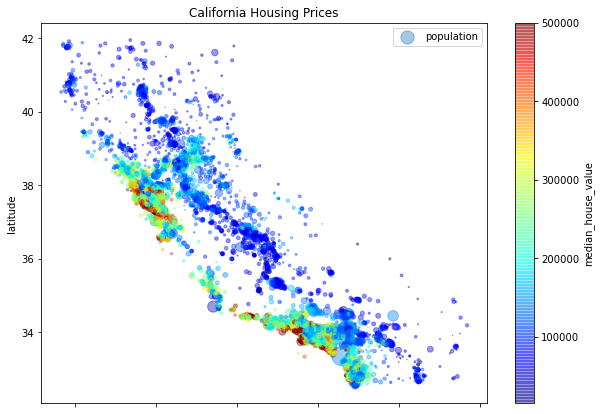

In [17]:
# tweaking more parameters to make patterns in the data to stand out
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()
plt.title('California Housing Prices');

The radius of each circle represents the district’s population (option `s`), and the color represents the price (option `c`). We also  use a predefined color map (option  `cmap`)  called  `jet`,  which  ranges  from  blue(low values) to red (high prices)

### Looking for correlations

In [18]:
# computing the Pearson's correlation coefficient over
# each pair of features in the dataset
corr_matrix = housing.corr()

# checking how each attribute correlates with the median house value
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
id                   -0.047632
latitude             -0.142724
Name: median_house_value, dtype: float64

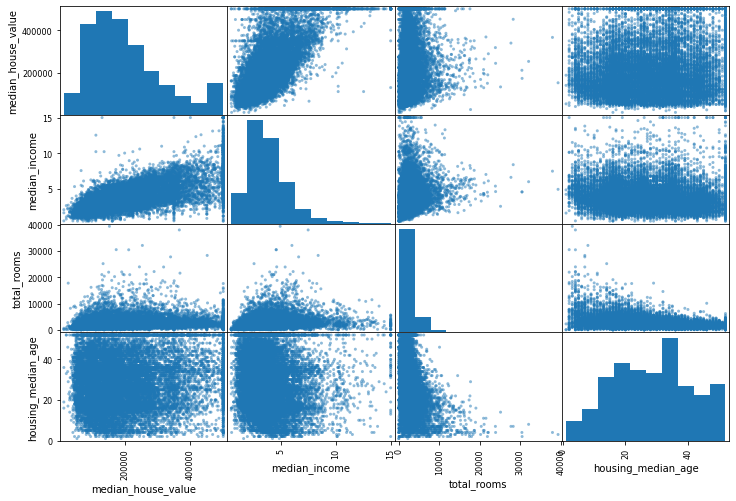

In [19]:
# another way to check for correlation between attributes
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8));

The most promising attribute to predict the median house value is the median income.

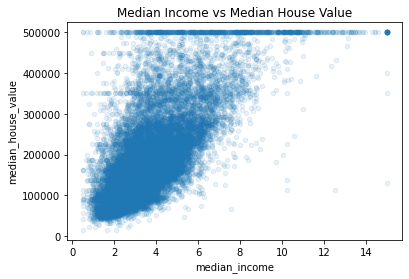

In [20]:
# zooming in on median income scatterplot
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.title('Median Income vs Median House Value');

The plot above reveals other less obvious straight lines:
 - a  horizontal  line  around  \$450,000
 - another around \$350,000
 - perhaps one around \$280,000, and a few more below that.

### Experimenting with attribute combinations

In [21]:
# deriving attributes from existing features
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

# looking at the correlation matrix again
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
id                         -0.047632
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Preparing the data for Machine Learning algorithms

In [22]:
# obtain a clean training set and isolate the labels
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning

We can deal with missing values in `total_bedrooms` column in any of the following ways:

1. Getting rid of the corresponding districts
```python
housing.dropna(subset=["total_bedrooms"])
```

1. Getting rid of the whole attribute
```python
housing.drop("total_bedrooms", axis=1)
```

1. Imputation
```python
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)
```

In [23]:
# using sklearn's tools to impute missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1) # get numeric attributes
imputer.fit(housing_num);

In [24]:
# comparing computed statistics
print('SimpleImputer: {}'.format(imputer.statistics_))
print('computed directly: {}'.format(housing_num.median().values))

SimpleImputer: [-1.18510000e+02  3.42600000e+01  2.90000000e+01  2.11950000e+03
  4.33000000e+02  1.16400000e+03  4.08000000e+02  3.54090000e+00
 -1.18475925e+05]
computed directly: [-1.18510000e+02  3.42600000e+01  2.90000000e+01  2.11950000e+03
  4.33000000e+02  1.16400000e+03  4.08000000e+02  3.54090000e+00
 -1.18475925e+05]


In [25]:
# transforming the training set with the trained imputer
X = imputer.transform(housing_num)

# creating a dataframe from the resulting array
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

### Handling text and categorical attributes

In [26]:
# we had left out `ocean_proximity` since we couldn't compute its median
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [27]:
# we convert the categories from text to numbers
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [28]:
# getting the list of categories
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

There is an issue with the above representation: ML algorithms might assume `0` < `1` < `2` < `3` < `4`, which is not the case with ocean proximity. We can use **one-hot-encoding** - having a binary attribute per category - to resolve this issue.

In [29]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot # returns a scipy sparse matrix

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [30]:
# getting the list of categories
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformers

By adding `TransformerMixin` as a base class, you get `fit_transform`, `get_params` and `set_params` methods implemented. The last two are useful for automatic hyperparameter tuning.

**Note:** Don't use `*args` or `**kwargs`

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

# creates derived attributes shown earlier
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Transformation Pipelines

**Note:** Names of steps must be unique and shouldn't contain double underscores (`__`)

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# pipeline for preprocessing numerical attributes
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [33]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)

## Selecting and Training a Model

### Training and evaluating on the training set

In [34]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels);

In [35]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [210007.75 318953.5  211720.75  58941.75 189533.5 ]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [36]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68624.58762021299

The model clearly underfits the data, so we select a more powerful model.

In [37]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels);

In [38]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

The model most probably overfits the data.

### Using cross-validation

In [39]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [40]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [69805.04964522 66872.46434683 69461.44154723 69211.65110365
 70568.35063258 75630.50030848 69212.39435478 68245.38229181
 76756.24045864 68636.0637673 ]
Mean: 70439.95384565217
Standard deviation: 3033.5968672606746


In [41]:
# computing the same metrics for the linear regression model
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66794.08078101 66985.33426792 70340.2765274  74729.22717287
 68018.29728172 71203.32949522 64954.20773829 68277.64684663
 71537.98651081 67668.50963198]
Mean: 69050.88962538668
Standard deviation: 2728.41194772955


The decision tree fits much worse than the linear regression model. We'll try out the random forest model.

In [42]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels);

In [43]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse 

18610.995154464345

In [44]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [49292.05888881 47709.07801823 49870.77425801 51929.42815523
 49398.0708476  53289.59452085 48379.32383089 47876.35139571
 52709.7130628  50007.76517014]
Mean: 50046.21581482527
Standard deviation: 1874.3096879384834


The random forest model seems promising. We should experiment with several more models without much hyperparameter tuning, in order to shortlist two to five candidate models.

We should save every model we experiment with, together with its hyperparameters, cross-validation scores or even predictions in order to make it easy to compare different models.

We can save Scikit-Learn models using Python's pickle module, or using `sklearn.externals.joblib` which is more efficient at serializing large Numpy arrays.

```python
from sklearn.externals import joblib

joblib.dump(my_model, "my_model.pkl")

# and later...
my_model_loaded = joblib.load("my_model.pkl")
```

## Fine-tuning the model

In [45]:
# using grid search to find the best hyperparameters for the random forest model
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [46]:
# getting the best set of hyperparameters
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [47]:
# getting the best estimator
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [48]:
# viewing the evaluation scores
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

61807.69612667671 {'max_features': 2, 'n_estimators': 3}
53289.64692643598 {'max_features': 2, 'n_estimators': 10}
51050.50367382931 {'max_features': 2, 'n_estimators': 30}
57882.11175896126 {'max_features': 4, 'n_estimators': 3}
51231.17360482185 {'max_features': 4, 'n_estimators': 10}
48601.206658159885 {'max_features': 4, 'n_estimators': 30}
57384.365955211244 {'max_features': 6, 'n_estimators': 3}
50919.95325156806 {'max_features': 6, 'n_estimators': 10}
48489.14308174238 {'max_features': 6, 'n_estimators': 30}
57271.88407701023 {'max_features': 8, 'n_estimators': 3}
51033.2838533679 {'max_features': 8, 'n_estimators': 10}
49090.96198400052 {'max_features': 8, 'n_estimators': 30}
59891.18600679962 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
52489.786553505226 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
58316.113704124946 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
50285.772903608144 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [49]:
# obtaining feature importances from the random forest model
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([4.21979937e-02, 6.39872276e-02, 3.72960307e-02, 1.57983615e-02,
       1.47261522e-02, 1.52349568e-02, 1.52416313e-02, 3.55648128e-01,
       6.70002484e-02, 5.56387941e-02, 9.94957098e-02, 5.98335440e-02,
       1.19829487e-02, 1.37310561e-01, 5.98223003e-05, 3.55432960e-03,
       4.99356008e-03])

In [50]:
# display scores next to their corresponding attribute names
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.35564812810882845, 'median_income'),
 (0.13731056091250834, 'INLAND'),
 (0.09949570982914817, 'pop_per_hhold'),
 (0.06700024839546032, 'id'),
 (0.0639872275786228, 'latitude'),
 (0.059833543953614045, 'bedrooms_per_room'),
 (0.05563879409082233, 'rooms_per_hhold'),
 (0.0421979937410633, 'longitude'),
 (0.03729603073014638, 'housing_median_age'),
 (0.015798361542781567, 'total_rooms'),
 (0.015241631342657009, 'households'),
 (0.015234956813676313, 'population'),
 (0.014726152249349188, 'total_bedrooms'),
 (0.011982948731840136, '<1H OCEAN'),
 (0.0049935600799391995, 'NEAR OCEAN'),
 (0.0035543295992236943, 'NEAR BAY'),
 (5.982230031878519e-05, 'ISLAND')]

### Evaluate the model on the test set

In [51]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test) # we call transform since we don't want to fit on the test set

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print('Test set RSME: {}'.format(final_rmse))

Test set RSME: 46589.03643771567


In [52]:
# computing the 95% confidence interval for the model's generalization error
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([44636.82689677, 48462.66931337])